In [26]:
%matplotlib inline
from gensim.models import Word2Vec
import sys
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn import tree
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# load the model containing features
node2vecmodel = Word2Vec.load_word2vec_format("../big.bin" , binary=False)

In [21]:
X = []
Y = []
X_test = []
Y_test = []

def handle_features(source, target):
    features_source = node2vecmodel[source]
    features_target = node2vecmodel[target]
    return features_source * features_target

# load all training pairs

test_data = {}
with open("test_data.csv") as f:
    for line in f:
        source, target = tuple(line.split())
        if source in node2vecmodel and target in node2vecmodel:
            features = handle_features(source, target)
            #label = -1 if int(label) == 0 else 1
            label = 1
            Y_test.append(label)
            X_test.append(features)
        if source not in test_data:
            test_data[source] = [target]
        else:
            test_data[source].append(target)

i = 0
neg_counter = 0
with open("trainingPairs_n_gram") as f:
    for line in f:
        source, target, label = tuple(line.split())
        # ignore positives
        if label == "1": continue
        if source in node2vecmodel and target in node2vecmodel:
            features = handle_features(source, target)
            #label = -1 if int(label) == 0 else 1
            label = int(label)
            Y.append(label)
            X.append(features)
            neg_counter += 1
        else:
            i += 1
            
pos_counter = 0
# load positives from here
with open("trainingPairs.txt") as f:
    for line in f:
        if pos_counter < neg_counter:
            source, target, label = tuple(line.split())
            if label == "0": continue
            if source in node2vecmodel and target in node2vecmodel:
                # we want to ignore the test_data
                if source in test_data and target in test_data[source]:
                    continue
                features = handle_features(source, target)
                #label = -1 if int(label) == 0 else 1
                label = int(label)
                Y.append(label)
                X.append(features)
                pos_counter += 1
            else:
                i += 1
        else: break

print(len([x for x in Y if x == 0]))
print(len([x for x in Y if x == 1]))

print(i)
X = np.array(X)
Y = np.array(Y)
X_test = np.array(X_test)
Y_test = np.array(Y_test)



39679
39679
23208


-------------------------SGD-----------------------------------
Classification report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.50      0.67     64435

avg / total       1.00      0.50      0.67     64435

F1 score:
0.669811418132
Confusion matrix:
[[    0     0]
 [31989 32446]]
Normalized confusion matrix
[[        nan         nan]
 [ 0.49645379  0.50354621]]
-------------------------Dummy-----------------------------------
Classification report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.50      0.67     64435

avg / total       1.00      0.50      0.67     64435

F1 score:
0.665099079129
Confusion matrix:


/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[[    0     0]
 [32331 32104]]
Normalized confusion matrix
[[        nan         nan]
 [ 0.50176147  0.49823853]]
-------------------------Keras-----------------------------------
Epoch 1/100
79358/79358 [==============================] - 1s - loss: 0.1522     
Epoch 2/100
79358/79358 [==============================] - 1s - loss: 0.1082     
Epoch 3/100
79358/79358 [==============================] - 1s - loss: 0.1019     
Epoch 4/100
79358/79358 [==============================] - 1s - loss: 0.0990     
Epoch 5/100
79358/79358 [==============================] - 1s - loss: 0.0971     
Epoch 6/100
79358/79358 [==============================] - 1s - loss: 0.0956     
Epoch 7/100
79358/79358 [==============================] - 1s - loss: 0.0946     
Epoch 8/100
79358/79358 [==============================] - 1s - loss: 0.0938     
Epoch 9/100
79358/79358 [==============================] - 1s - loss: 0.0931     
Epoch 10/100
79358/79358 [==============================] - 1s - loss: 0.0924     

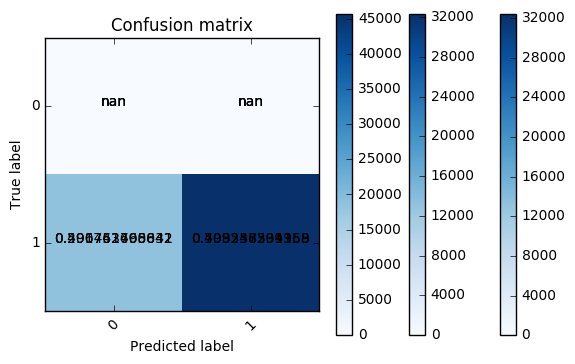

In [33]:
num_folds = 3
seed = 7
# prepare models
models = []
#models.append(('SGD', SGDClassifier(loss="hinge", penalty="l2")))
# sanity check
models.append(('Dummy', DummyClassifier("uniform")))
def keras_baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=128, init='normal', activation='relu'))
    model.add(Dense(1, init='normal', activation="relu"))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
models.append(('Keras', KerasClassifier(build_fn=keras_baseline_model, nb_epoch=100, batch_size=128, verbose=1)))

#models.append(('Gradient Boosting', GradientBoostingClassifier()))

# Split the dataset in two equal parts
#X_train, X_test, y_train, y_test = train_test_split(
#    X, Y, test_size=0.5, random_state=0)


# evaluate each model in turn
results = []
names = []
scoring = 'f1'
for name, model in models:
    print("-------------------------" + name + "-----------------------------------")
    #kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    #cv_results = cross_val_score(model, X, y=Y, cv=kfold, scoring=scoring)
    #results.append(cv_results)
    #names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg)
    
    model.fit(X, Y)
    y_true, y_pred = Y_test, model.predict(X_test)
    print("Classification report:")
    print(classification_report(y_true, y_pred))
    
    print("F1 score:")
    print(f1_score(y_true, y_pred))
    
    print("Confusion matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    plot_confusion_matrix(cm, ["0", "1"], normalize=True) 
    

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')